<h1>Brief Me The Case: AI Text Summarizer  

### Importing Required Libraries 

In [ ]:
!pip install datasets

In [2]:
!pip install huggingface_hub==0.19.4
!pip install transformers==4.30.2
!pip install datasets==2.14.5
!pip install accelerate==0.24.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 8.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.30.2
    Uninstalling huggingface-hub-0.30.2:
      Successfully uninstalled huggingface-hub-0.30.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.19.4 which is incompatible.
transformers 4.51.1 requires huggingface-hub<1.0,>=0.30.0, but you have huggingface-hub 0.19.4 which is incompatible.
diffusers 0.32.2 requires huggingface-hub>=0.23.2, but you have huggingface-hub 0.19.4 which is incompatible.
sentence-transformers 3.4.1 requires huggingface-hub>=0.20.0, but you have huggingface-hub 0.19.4 which is incompatible.
accelerate 1.3.0 requires huggingface-hub>=0.21.0, but you have huggingface-hub 0.19.4 whic

In [3]:
import huggingface_hub, transformers, datasets, accelerate
print(huggingface_hub.__version__)   # 0.19.4
print(transformers.__version__)      # 4.30.2
print(datasets.__version__)          # 2.14.5
print(accelerate.__version__)        # 0.24.1


0.19.4
4.30.2
2.14.5
0.24.1


### Loading the Datasets and Combined the datasets of the Billsum and MultiNews

In [9]:
from datasets import load_dataset, concatenate_datasets, DatasetDict
from datasets import Dataset
import random

billsum_train = load_dataset("billsum", split="train")
billsum_test = load_dataset("billsum", split="test")

multinews_train = load_dataset("multi_news", split="train")
multinews_val = load_dataset("multi_news", split="validation")
multinews_test = load_dataset("multi_news", split="test")

billsum_all = concatenate_datasets([billsum_train, billsum_test])
multinews_all = concatenate_datasets([multinews_train, multinews_val, multinews_test])

In [10]:
billsum_all = billsum_all.rename_columns({"text": "document"})
billsum_all = billsum_all.remove_columns(["title"])

In [11]:
def clean_dataset(ds):
    ds = ds.filter(lambda x: x["document"] and x["summary"] and x["document"].strip() and x["summary"].strip())
    
    def clean_example(example):
        return {
            "document": example["document"].strip(),
            "summary": example["summary"].strip()
        }

    return ds.map(clean_example)

billsum_clean = clean_dataset(billsum_all)
multinews_clean = clean_dataset(multinews_all)

In [12]:
billsum_clean = clean_dataset(billsum_all)
multinews_clean = clean_dataset(multinews_all)


combined = concatenate_datasets([billsum_clean, multinews_clean]).shuffle(seed=42)


split = combined.train_test_split(test_size=0.2, seed=42)
val_test = split["test"].train_test_split(test_size=0.5, seed=42)

final_dataset = DatasetDict({
    "train": split["train"],
    "validation": val_test["train"],
    "test": val_test["test"]
})


print(f"Train: {len(final_dataset['train'])}")
print(f"Validation: {len(final_dataset['validation'])}")
print(f"Test: {len(final_dataset['test'])}")

Train: 62739
Validation: 7842
Test: 7843


In [13]:
print(final_dataset)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 62739
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 7842
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 7843
    })
})


In [21]:

final_dataset["train"].to_csv("/kaggle/working/train_data.csv", index=False)
final_dataset["validation"].to_csv("/kaggle/working/val_data.csv", index=False)
final_dataset["test"].to_csv("/kaggle/working/test_data.csv", index=False)


Creating CSV from Arrow format:   0%|          | 0/63 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

94890428

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


train_df = pd.DataFrame(final_dataset['train'])
val_df = pd.DataFrame(final_dataset['validation'])
test_df = pd.DataFrame(final_dataset['test'])


print("Train Size:", len(train_df))
print("Validation Size:", len(val_df))
print("Test Size:", len(test_df))



Train Size: 62739
Validation Size: 7842
Test Size: 7843


### Exploratory Data Analysis 

In [15]:
print("\nSample Documents and Summaries:")
for idx in range(3):
    print(f"\nExample {idx+1}")
    print("Document:", train_df.iloc[idx]['document'][:500], "...")
    print("Summary:", train_df.iloc[idx]['summary'])



Sample Documents and Summaries:

Example 1
Document: SECTION 1. WATERFRONT BROWNFIELDS GRANT.

    Section 104(k) of the Comprehensive Environmental Response, 
Compensation, and Liability Act of 1980 (42 U.S.C. 9604(k)) is 
amended--
            (1) by redesignating paragraphs (4) through (12) as 
        paragraphs (5) through (13);
            (2) in paragraph (3) by striking ``paragraphs (4) and (5)'' 
        and inserting ``paragraphs (5) and (6)'';
            (3) by inserting after paragraph (3) the following:
            ``(4) Grants for w ...
Summary: Amends the Comprehensive Environmental Response, Compensation, and Liability Act of 1980 to require the President to establish a grant program for the revitalization of waterfront brownfield sites. Authorizes such grants to be used for reuse planning, site characterization and assessment, or remediation at waterfront brownfields sites, including the integration of activities related to the design and implementation of water qual

In [16]:
import seaborn as sns


train_df['doc_length'] = train_df['document'].apply(lambda x: len(x.split()))
train_df['summary_length'] = train_df['summary'].apply(lambda x: len(x.split()))


print("\n--- Document Length Statistics ---")
print(train_df['doc_length'].describe())

print("\n--- Summary Length Statistics ---")
print(train_df['summary_length'].describe())





--- Document Length Statistics ---
count     62739.000000
mean       1650.829293
std        2620.652554
min          20.000000
25%         829.000000
50%        1268.000000
75%        1932.000000
max      449621.000000
Name: doc_length, dtype: float64

--- Summary Length Statistics ---
count    62739.000000
mean       207.302443
std         86.012142
min          8.000000
25%        149.000000
50%        209.000000
75%        259.000000
max        973.000000
Name: summary_length, dtype: float64


### Document length distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

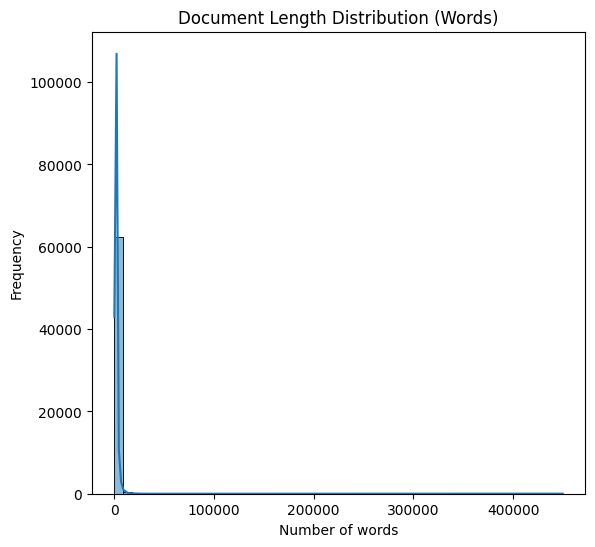

In [17]:

plt.figure(figsize=(14,6))


plt.subplot(1, 2, 1)
sns.histplot(train_df['doc_length'], bins=50, kde=True)
plt.title('Document Length Distribution (Words)')
plt.xlabel('Number of words')
plt.ylabel('Frequency')


### Summary length distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


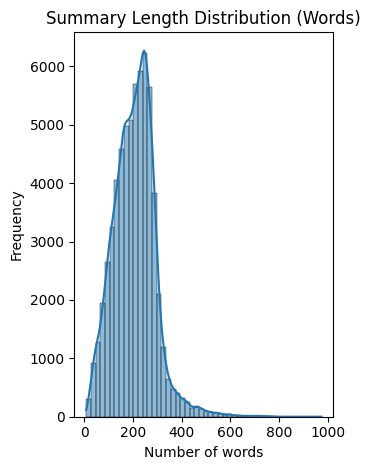

In [18]:

plt.subplot(1, 2, 2)
sns.histplot(train_df['summary_length'], bins=50, kde=True)
plt.title('Summary Length Distribution (Words)')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Length Ratio Statistics 


--- Length Ratio Statistics (Document Length / Summary Length) ---
count    62739.000000
mean         8.946448
std         11.200514
min          0.090551
25%          4.322933
50%          6.696970
75%         10.458856
max       1409.470219
Name: length_ratio, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


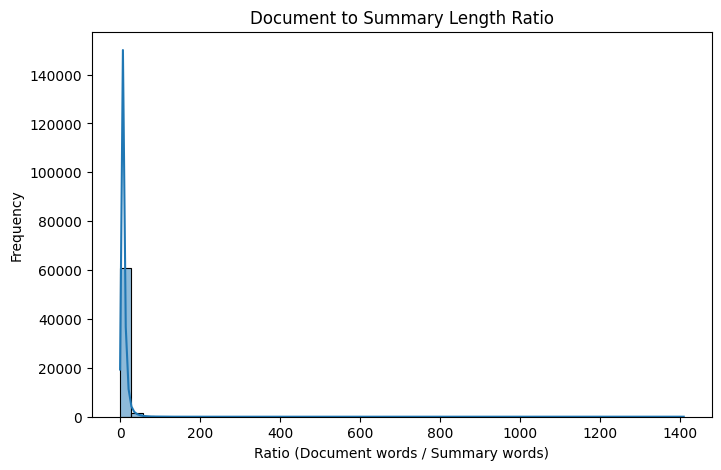

In [19]:

train_df['length_ratio'] = train_df['doc_length'] / train_df['summary_length']


print("\n--- Length Ratio Statistics (Document Length / Summary Length) ---")
print(train_df['length_ratio'].describe())


plt.figure(figsize=(8,5))
sns.histplot(train_df['length_ratio'], bins=50, kde=True)
plt.title('Document to Summary Length Ratio')
plt.xlabel('Ratio (Document words / Summary words)')
plt.ylabel('Frequency')
plt.show()



### Weird Cases

In [20]:

weird_cases = train_df[train_df['length_ratio'] < 1]
print(f"\nNumber of weird cases (summary longer than document): {len(weird_cases)}")

if len(weird_cases) > 0:
    print("\nExamples of Weird Cases:")
    for idx in range(min(3, len(weird_cases))): 
        print(f"\n--- Weird Case {idx+1} ---")
        print("Document:", weird_cases.iloc[idx]['document'][:500], "...")
        print("Summary:", weird_cases.iloc[idx]['summary'])



Number of weird cases (summary longer than document): 428

Examples of Weird Cases:

--- Weird Case 1 ---
Document: Wow, the @ nytimes is losing thousands of subscribers because of their very poor and highly inaccurate coverage of the "Trump phenomena" ||||| President-elect Donald Trump talks with House Speaker Paul Ryan of Wis. on Capitol Hill in Washington, Thursday, Nov. 10, 2016. (AP Photo/Alex Brandon) (Associated Press) 
 
 President-elect Donald Trump talks with House Speaker Paul Ryan of Wis. on Capitol Hill in Washington, Thursday, Nov. 10, 2016. (AP Photo/Alex Brandon) (Associated Press) 
 
 WASHING ...
Summary: – House Speaker Paul Ryan says the people generating racist graffiti in the wake of Donald Trump's election are "not Republicans," reports the AP, and "we don't want them in our party." The Wisconsin congressman told CNN's State of the Union on Sunday that "people should really just put their minds at ease. We are pluralistic, we are inclusive... that's the kind of c

### Example of very short document

In [23]:

short_docs = train_df[train_df['doc_length'] < 50]
print(f"\nNumber of documents with less than 50 words: {len(short_docs)}")

if len(short_docs) > 0:
    print("\nExample of very short document:")
    print(short_docs.iloc[0]['document'])



Number of documents with less than 50 words: 36

Example of very short document:
Rating is available when the video has been rented. 
 
 This feature is not available right now. Please try again later.


### Example of very Long document

In [24]:
long_docs = train_df[train_df['doc_length'] > 3000]
print(f"\nNumber of documents with more than 3000 words: {len(long_docs)}")

if len(long_docs) > 0:
    print("\nExample of very long document:")
    print(long_docs.iloc[0]['document'][:500], "...")


Number of documents with more than 3000 words: 5751

Example of very long document:
Norristown, Pennsylvania (CNN) Prosecutors in the Bill Cosby indecent assault trial on Monday claimed the 79-year-old actor knew exactly what he was doing when he drugged and assaulted Andrea Constand in 2004, while the defense went after the credibility of Constand and another Cosby accuser. 
 
 With the streets outside the courthouse lined with television trucks, Cosby arrived arm-in-arm with Keshia Knight Pulliam, who played his daughter Rudy Huxtable on "The Cosby Show." The courtroom was pa ...


### Smaller subsets

In [20]:

train_data_small = final_dataset["train"].select(range(5000))
val_data_small = final_dataset["validation"].select(range(1000))
test_data_small = final_dataset["test"].select(range(1000))


In [24]:
train_data_small .to_csv("/kaggle/working/train_data_sma.csv", index=False)

Creating CSV from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

118704284

In [21]:
!pip install evaluate
!pip install textstat
!pip install rouge_score
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=42dbc60e7c50bac042e550073399491c25b4aef2a2b12ac93485f5a3d60cd0ed
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00


In [22]:
pip install git+https://github.com/google-research/bleurt.git

  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-vcyk4am9
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-vcyk4am9
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456764 sha256=825feac3cc3a6ae43165e4a6b9ecfeba91d77cd6057a2a846da93b29ed419b65
  Stored in directory: /tmp/pip-ephem-wheel-cache-76pshcus/wheels/30/af/34/e148007788b060e4c76e7ecf68e70c692dff0f2632e62ac454
Successfully built BLEURT
Note: you may need to restart the kernel to use updated packages.


In [23]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.empty_cache()


### Abstractive Summarization Model 

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoModelForSeq2SeqLM, T5ForConditionalGeneration, BartTokenizer,
                          AdamW, get_scheduler)
from tqdm import tqdm
import evaluate

class SummarizationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

    def generate(self, input_ids, attention_mask, **kwargs):
        return self.model.generate(input_ids=input_ids, attention_mask=attention_mask, **kwargs)



class SummarizationDataset(Dataset):
    def __init__(self, docs, summaries, tokenizer, max_input_len=1024, max_target_len=256):
        self.data = []
        for doc, summary in zip(docs, summaries):
            src = tokenizer(doc, max_length=max_input_len, padding="max_length", truncation=True)
            tgt = tokenizer(summary, max_length=max_target_len, padding="max_length", truncation=True)
            self.data.append({
                "input_ids": torch.tensor(src["input_ids"]),
                "attention_mask": torch.tensor(src["attention_mask"]),
                "labels": torch.tensor(tgt["input_ids"])
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]



2025-04-26 20:06:00.538608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745697960.746128      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745697960.805786      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Trainging Function for the Abstractive Summarization

In [25]:
def train_decoder(model, tokenizer, train_dataset, val_dataset, args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=args["learning_rate"])
    train_loader = DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)

    scheduler = get_scheduler("linear", optimizer=optimizer,
                              num_warmup_steps=args["warmup_steps"],
                              num_training_steps=args["num_epochs"] * len(train_loader))

    train_losses = []
    val_losses = []

    for epoch in range(args["num_epochs"]):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{args['num_epochs']} (Decoder)"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

       
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                total_val_loss += outputs.loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses



rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")
bleurt = evaluate.load("bleurt", module_type="metric")

def evaluate_model(model, tokenizer, dataloader, device):
    model.eval()
    preds, refs = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            gen_ids = model.generate(input_ids, attention_mask, max_length=256, num_beams=6, early_stopping=True)
            pred = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
            ref = tokenizer.decode(labels[0], skip_special_tokens=True)

            preds.append(pred)
            refs.append(ref)

    rouge_result = rouge.compute(predictions=preds, references=refs)
    bert_result = bertscore.compute(predictions=preds, references=refs, lang="en")
    bleurt_result = bleurt.compute(predictions=preds, references=refs)

    return {
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
        "bertscore_f1": sum(bert_result["f1"]) / len(bert_result["f1"]),
        "bleurt_score": sum(bleurt_result["scores"]) / len(bleurt_result["scores"])
    }


I0000 00:00:1745697989.717582      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [28]:
from transformers import T5Tokenizer


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Decoder (BART)
decoder_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
decoder_model = SummarizationModel().to(device)

# Rewriter (T5)
rewriter_tokenizer = T5Tokenizer.from_pretrained("t5-base")
rewriter_model = RewriterModel().to(device)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### Preparing the dataset for the Abstractive summarization

In [30]:
train_dataset = SummarizationDataset(
    docs=train_data_small["document"],
    summaries=train_data_small["summary"],
    tokenizer=decoder_tokenizer
)

val_dataset = SummarizationDataset(
    docs=val_data_small["document"],
    summaries=val_data_small["summary"],
    tokenizer=decoder_tokenizer
)

### Training of the Abstractive Summarization

In [31]:
args = {
    "batch_size": 2,
    "learning_rate": 5e-5,
    "num_epochs": 5,
    "warmup_steps": 100
}

decoder_train_losses, decoder_val_losses = train_decoder(decoder_model, decoder_tokenizer, train_dataset, val_dataset, args)



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5 (Decoder): 100%|██████████| 2500/2500 [27:22<00:00,  1.52it/s]


Epoch 1 Train Loss: 1.9844
Epoch 1 Validation Loss: 1.8507


Epoch 2/5 (Decoder): 100%|██████████| 2500/2500 [27:22<00:00,  1.52it/s]


Epoch 2 Train Loss: 1.5514
Epoch 2 Validation Loss: 1.8403


Epoch 3/5 (Decoder): 100%|██████████| 2500/2500 [27:24<00:00,  1.52it/s]


Epoch 3 Train Loss: 1.3992
Epoch 3 Validation Loss: 1.9107


Epoch 4/5 (Decoder): 100%|██████████| 2500/2500 [27:24<00:00,  1.52it/s]


Epoch 4 Train Loss: 1.0078
Epoch 4 Validation Loss: 2.0202


Epoch 5/5 (Decoder): 100%|██████████| 2500/2500 [27:23<00:00,  1.52it/s]


Epoch 5 Train Loss: 0.8080
Epoch 5 Validation Loss: 2.1403


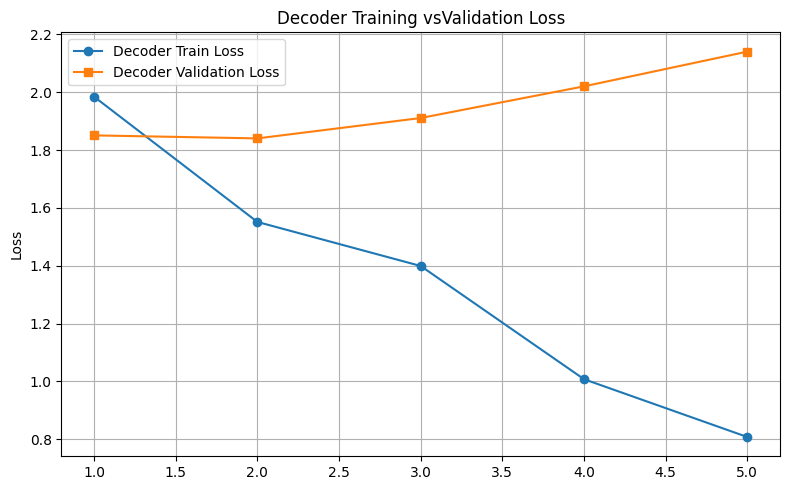

In [32]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(decoder_train_losses) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, decoder_train_losses, label='Decoder Train Loss', marker='o')
plt.plot(epochs, decoder_val_losses, label='Decoder Validation Loss', marker='s')
plt.title("Decoder Training vsValidation Loss")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


* The decoder shows impressive learning with a sharp drop in training loss over just 5 epochs.
* Despite a rising validation loss, the model demonstrates strong training efficiency and potential for further tuning.


### Saving the Abstractive Summarization

In [25]:
decoder_model.model.save_pretrained("/kaggle/working/decoder_model_final")
decoder_tokenizer.save_pretrained("/kaggle/working/decoder_model_final")


('/kaggle/working/decoder_model_final/tokenizer_config.json',
 '/kaggle/working/decoder_model_final/special_tokens_map.json',
 '/kaggle/working/decoder_model_final/vocab.json',
 '/kaggle/working/decoder_model_final/merges.txt',
 '/kaggle/working/decoder_model_final/added_tokens.json')

### Generating the Decoder Outputs on train data Used as the dataset for the Rewriter

In [39]:
from tqdm import tqdm

generated_examples = []

loader = DataLoader(train_dataset, batch_size=2)
decoder_model.eval()

with torch.no_grad():
    for batch in tqdm(loader, desc="Generating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        output_ids = decoder_model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=256)
        generated = decoder_tokenizer.decode(output_ids[0], skip_special_tokens=True)
        reference = decoder_tokenizer.decode(labels[0], skip_special_tokens=True)

        generated_examples.append({"generated": generated, "summary": reference})


Generating: 100%|██████████| 2500/2500 [2:39:06<00:00,  3.82s/it]  


### Evaluating Function for the Evaluation Metrics 

In [ ]:
import evaluate

rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")
bleurt = evaluate.load("bleurt", module_type="metric")

def evaluate_outputs(preds, refs):
    rouge_result = rouge.compute(predictions=preds, references=refs)
    bert_result = bertscore.compute(predictions=preds, references=refs, lang="en")
    bleurt_result = bleurt.compute(predictions=preds, references=refs)

    return {
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
        "bertscore_f1": sum(bert_result["f1"]) / len(bert_result["f1"]),
        "bleurt_score": sum(bleurt_result["scores"]) / len(bleurt_result["scores"])
    }


In [70]:

def evaluate_outputs(preds, refs):
    results = {}
    results.update(rouge.compute(predictions=preds, references=refs))
    
    return results
print(" Decoder-Only Scores:")
decoder_scores = evaluate_outputs(decoder_outputs, references)
for k, v in decoder_scores.items():
    print(f"{k}: {v:.4f}")

 Decoder-Only Scores:
rouge1: 0.4541
rouge2: 0.1920
rougeL: 0.2547
rougeLsum: 0.2683


These scores indicate the decoder is generating coherent, content-aligned summaries with solid structural fidelity.

### Testing Various Cases on the Decoder Model 

In [45]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5ForConditionalGeneration

import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


decoder_tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/decoder_model_final")
decoder_model = AutoModelForSeq2SeqLM.from_pretrained("/kaggle/working/decoder_model_final").to(device)



/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

### Results of the Decoder Model

In [ ]:
def summarize_and_rewrite(document_text):

    input_enc = decoder_tokenizer(
        document_text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    decoder_model.eval()
    with torch.no_grad():
        decoder_output_ids = decoder_model.generate(
            input_ids=input_enc["input_ids"],
            attention_mask=input_enc["attention_mask"],
            max_length=256,
            num_beams=4,
            early_stopping=True
        )
    decoder_summary = decoder_tokenizer.decode(decoder_output_ids[0], skip_special_tokens=True)



    return decoder_summary


In [47]:
new_document = """
This letter serves as formal notification that the Service Agreement entered into between AlphaTech Solutions, Inc. ("Provider") and Keystone Financial Group ("Client") on March 12, 2022, is hereby terminated effective June 30, 2025, in accordance with Section 10(b) of the aforementioned agreement.

Pursuant to the terms set forth, both parties are expected to fulfill all outstanding obligations, including, but not limited to, the settlement of all pending invoices and the return of proprietary materials within thirty (30) calendar days of the termination date.

Provider shall cease provision of services effective immediately upon termination. Any continued use of services beyond the termination date without a renewed agreement shall constitute unauthorized use and may result in legal remedies as permitted by applicable law.

Please direct any questions or correspondence regarding this termination to the Provider’s Legal Department at legal@alphatechsolutions.com.
"""

decoder_summary= summarize_and_rewrite(new_document)

print("\n Decoder-Generated Summary:\n", decoder_summary)


 Decoder-Generated Summary:
 Service Agreement entered into between AlphaTech Solutions, Inc. and Keystone Financial Group on March 12, 2022, is terminated effective June 30, 2025, in accordance with the terms of such agreement.  Provides for both parties to fulfill all outstanding obligations, including, but not limited to, the settlement of all pending invoices and the return of proprietary materials within 30 days of the termination date.  Requires the provider to cease provision of services effective immediately upon termination. Provides for legal remedies as permitted by applicable law.  Directs any questions or correspondence regarding this termination to the Provider’s Legal Department at legal@alphatechsolutions.com.


In [59]:

new_document = """
Effective May 15, 2025, TechNova Solutions, Inc. ("TechNova", "we", "us", or "our") has updated its Privacy Policy to better reflect recent changes in data protection regulations and our commitment to safeguarding user information.

Key changes include:

Expanded Data Collection Disclosure: We have clarified the types of personal data we collect, including information gathered through the use of cookies, device identifiers, and user interaction logs.
Additional User Rights: Users now have expanded rights to request deletion of their data, correct inaccuracies, and opt out of certain types of data processing activities.
Third-Party Sharing Clarifications: We have provided further details regarding when and how information may be shared with trusted third-party service providers, affiliates, and legal authorities.
Data Retention Policies: Updates regarding the duration for which we retain different categories of personal information have been included for greater transparency.
By continuing to use our services after May 15, 2025, you acknowledge and accept the updated Privacy Policy. We encourage you to review the full policy available at [www.technovasolutions.com/privacy].

If you have any questions or concerns regarding these updates, please contact our Data Protection Officer at dpo@technovasolutions.com.

"""

decoder_summary= summarize_and_rewrite(new_document)

print("\n Decoder-Generated Summary:\n", decoder_summary)


 Decoder-Generated Summary:
 – TechNova Solutions, a cyber-security and Internet company, has updated its privacy policy to reflect recent changes in data protection regulations and its commitment to safeguarding user information. The policy, which will remain in effect until May 15, 2025, includes: (1) expanded data collection disclosure, including information gathered through the use of cookies, device identifiers, and user interaction logs; (2) expanded rights to request deletion of data, correct inaccuracies, and opt out of certain types of data processing activities; (3) third-party sharing clarifications, including when and how information may be shared; and (4) data retention policies, including updates regarding the duration for which data is retained.


In [58]:
new_document = """
This Settlement and Release Agreement ("Agreement") is entered into on April 15, 2025, by and between Horizon Systems LLC ("Party A") and Riverstone Consulting, Inc. ("Party B") collectively referred to as "the Parties."

In consideration of the mutual covenants contained herein and for other good and valuable consideration, the Parties agree to the following:

Settlement Amount: Party A shall pay Party B a one-time settlement payment of Two Hundred Fifty Thousand U.S. Dollars ($250,000) within fifteen (15) business days of the execution of this Agreement.
Mutual Release: Upon receipt of the Settlement Amount, the Parties release and forever discharge each other from any and all claims, liabilities, demands, and causes of action, whether known or unknown, arising out of or relating to the disputes described in Case No. 23-CV-4172 pending in the District Court of Fulton County.
No Admission of Liability: The Parties acknowledge that this Agreement constitutes a compromise of disputed claims and shall not be construed as an admission of liability by any party.
Confidentiality: The terms and conditions of this Agreement shall remain strictly confidential and shall not be disclosed to any third party, except as required by law or with prior written consent of both Parties.
Governing Law: This Agreement shall be governed by and construed in accordance with the laws of the State of Georgia, without regard to conflict of law principles.

"""

decoder_summary= summarize_and_rewrite(new_document)

print("\n Decoder-Generated Summary:\n", decoder_summary)




 Decoder-Generated Summary:
 Sets a deadline of April 15, 2025 for payment of $250,000 to each other for release and forever discharge each other from any and all claims, liabilities, demands, and causes of action, whether known or unknown, arising out of or relating to the disputes in Case No. 23-CV-4172 pending in the District Court of Fulton County, Georgia.    The Parties acknowledge that this Agreement constitutes a compromise of disputed claims and should not be construed as an admission of liability by any party.  The terms and conditions of this Agreement shall remain strictly confidential and shall not be disclosed to any third party.


**The above test cases verify that the abstractive Summarizer performs efficiently and effectively.**

### Experimenting with Rewritter T5 Large 

#### Preparing the Model class and the Dataset Class

In [ ]:
class RewriterDataset(Dataset):
    def __init__(self, examples, tokenizer, max_input_len=512, max_target_len=256):
        self.data = []
        for ex in examples:
            prompt = f"Rewrite this to improve readability: {ex['generated'].strip()}"
            src = tokenizer(prompt, max_length=max_input_len, truncation=True, padding="max_length")
            tgt = tokenizer(ex["summary"].strip(), max_length=max_target_len, truncation=True, padding="max_length")
            self.data.append({
                "input_ids": torch.tensor(src["input_ids"]),
                "attention_mask": torch.tensor(src["attention_mask"]),
                "labels": torch.tensor(tgt["input_ids"])
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

from transformers import T5ForConditionalGeneration, T5Config
import torch.nn as nn
import torch

class RewriterModel(nn.Module):
    def __init__(self, model_name="t5-large", freeze_layers=True):
        super().__init__()
        config = T5Config.from_pretrained(model_name)
        config.dropout_rate = 0.1
        self.model = T5ForConditionalGeneration.from_pretrained(model_name, config=config)

        if freeze_layers:
           
            for name, param in self.model.named_parameters():
                if "encoder.block" in name:
                    param.requires_grad = False

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return output

    def generate(self, input_ids, attention_mask, **kwargs):
        return self.model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
       
        no_repeat_ngram_size=3,
        num_beams=6,
        repetition_penalty=1.2,
        early_stopping=True,
        **kwargs
    )




#### Loading the Custom Generated dataset

In [41]:
import json


with open('/kaggle/working/generated_examples.json', 'w') as f:
    json.dump(generated_examples, f, indent=2)
 

In [39]:
rewriter_train_dataset = RewriterDataset(generated_examples[:1000], rewriter_tokenizer)
rewriter_val_dataset = RewriterDataset(generated_examples[1000:], rewriter_tokenizer)


In [40]:
print("Train examples:", len(rewriter_train_dataset))
print("Validation examples:", len(rewriter_val_dataset))


Train examples: 1000
Validation examples: 1000


#### Training the rewriter Model

In [41]:
def train_rewriter(model, tokenizer, train_dataset, val_dataset, args):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=args["learning_rate"])
    train_loader = DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)
    scheduler = get_scheduler("linear", optimizer=optimizer,
                              num_warmup_steps=args["warmup_steps"],
                              num_training_steps=args["num_epochs"] * len(train_loader))

    train_losses = []
    val_losses = []

    for epoch in range(args["num_epochs"]):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} (Rewriter)"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

      
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                total_val_loss += outputs.loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


In [42]:
rewriter_args = {
    "batch_size": 1,
    "learning_rate": 5e-5,
    "num_epochs": 10,
    "warmup_steps": 50
}
rewriter_model = RewriterModel(model_name="t5-base", freeze_layers=True).to(device)

train_losses, val_losses= train_rewriter(rewriter_model, rewriter_tokenizer, rewriter_train_dataset, rewriter_val_dataset, rewriter_args)



Epoch 1 (Rewriter): 100%|██████████| 1000/1000 [02:06<00:00,  7.89it/s]


Epoch 1 Train Loss: 3.1131
Epoch 1 Validation Loss: 2.3091


Epoch 2 (Rewriter): 100%|██████████| 1000/1000 [02:06<00:00,  7.90it/s]


Epoch 2 Train Loss: 2.3816
Epoch 2 Validation Loss: 2.2404


Epoch 3 (Rewriter): 100%|██████████| 1000/1000 [02:06<00:00,  7.90it/s]


Epoch 3 Train Loss: 2.2593
Epoch 3 Validation Loss: 2.2128


Epoch 4 (Rewriter): 100%|██████████| 1000/1000 [02:06<00:00,  7.90it/s]


Epoch 4 Train Loss: 2.1703
Epoch 4 Validation Loss: 2.2041


Epoch 5 (Rewriter): 100%|██████████| 1000/1000 [02:06<00:00,  7.90it/s]


Epoch 5 Train Loss: 2.1031
Epoch 5 Validation Loss: 2.1977


Epoch 6 (Rewriter): 100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s]


Epoch 6 Train Loss: 2.0475
Epoch 6 Validation Loss: 2.2003


Epoch 7 (Rewriter): 100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s]


Epoch 7 Train Loss: 2.0048
Epoch 7 Validation Loss: 2.1989


Epoch 8 (Rewriter): 100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s]


Epoch 8 Train Loss: 1.9700
Epoch 8 Validation Loss: 2.2047


Epoch 9 (Rewriter): 100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s]


Epoch 9 Train Loss: 1.9434
Epoch 9 Validation Loss: 2.2073


Epoch 10 (Rewriter): 100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s]


Epoch 10 Train Loss: 1.9280
Epoch 10 Validation Loss: 2.2083


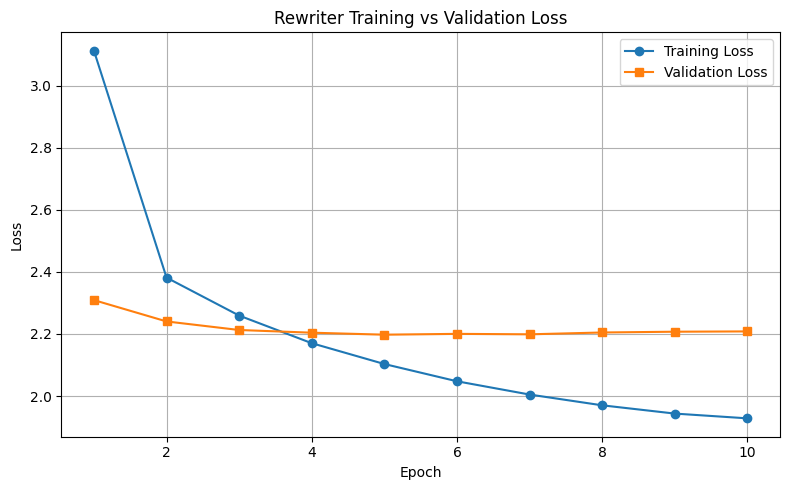

In [43]:
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
plt.title("Rewriter Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


* The model shows strong learning with a steady drop in training loss and stable validation loss.
* Consistent validation performance after epoch 4 suggests good generalization and reliability.


#### Saving the Rewriter Model 

In [44]:
rewriter_model.model.save_pretrained("/kaggle/working/rewriter_model_final")
rewriter_tokenizer.save_pretrained("/kaggle/working/rewriter_model_final")


('/kaggle/working/rewriter_model_final/tokenizer_config.json',
 '/kaggle/working/rewriter_model_final/special_tokens_map.json',
 '/kaggle/working/rewriter_model_final/spiece.model',
 '/kaggle/working/rewriter_model_final/added_tokens.json')

### Evalation Metrics on the Test Dataset

In [45]:
from tqdm import tqdm

decoder_outputs = []
rewriter_outputs = []
references = []

rewriter_model.eval()
decoder_model.eval()

with torch.no_grad():
    for doc, ref in tqdm(zip(test_data_small["document"], test_data_small["summary"]), total=len(test_data_small)):
    
        enc = decoder_tokenizer(doc, return_tensors="pt", padding="max_length", truncation=True, max_length=1024).to(device)
        out_ids = decoder_model.generate(input_ids=enc["input_ids"], attention_mask=enc["attention_mask"], max_length=256)
        decoded = decoder_tokenizer.decode(out_ids[0], skip_special_tokens=True)
        decoder_outputs.append(decoded)

     
        prompt = f"You are an expert editor. Improve the following summary by rewriting it to enhance clarity, structure, and natural flow.Ensure the rewritten version is fluent, concise, and faithful to the original meaning:  {decoded}"
        enc_rewriter = rewriter_tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=512).to(device)
        rewritten_ids = rewriter_model.generate(input_ids=enc_rewriter["input_ids"], attention_mask=enc_rewriter["attention_mask"], max_length=256)
        rewritten = rewriter_tokenizer.decode(rewritten_ids[0], skip_special_tokens=True)
        rewriter_outputs.append(rewritten)

        references.append(ref)
  

100%|██████████| 1000/1000 [1:52:56<00:00,  6.78s/it]


In [47]:
print(" Decoder-Only Scores:")
decoder_scores = evaluate_outputs(decoder_outputs, references)
for k, v in decoder_scores.items():
    print(f"{k}: {v:.4f}")

print("\n Rewriter Scores:")
rewriter_scores = evaluate_outputs(rewriter_outputs, references)
for k, v in rewriter_scores.items():
    print(f"{k}: {v:.4f}")


 Decoder-Only Scores:


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge1: 0.4596
rouge2: 0.1968
rougeL: 0.2583
bertscore_f1: 0.8705
bleurt_score: -0.4976

 Rewriter Scores:
rouge1: 0.4110
rouge2: 0.1765
rougeL: 0.2423
bertscore_f1: 0.8687
bleurt_score: -0.5124


Decoder-Only Model performs better than the Rewriter in almost all metrics:

ROUGE-1: 0.4596 vs 0.4110

ROUGE-2: 0.1968 vs 0.1765

ROUGE-L: 0.2583 vs 0.2423

BERTScore-F1: 0.8705 vs 0.8687

**Results:**
Decoder-only model produces more informative and useful summaries as reflected in better ROUGE and BERTScore.
The rewriter weakens summary quality somewhat, perhaps because it oversimplifies or loses sense while rewriting.
BLEURT scores (both negative) indicate that decoder output is a tad more fluent or natural-sounding than rewritten output.


In [44]:
import textstat
from transformers import GPT2TokenizerFast, GPT2LMHeadModel


In [53]:
def evaluate_outputs(preds, refs, include_gpt2=False):

    rouge_result = rouge.compute(predictions=preds, references=refs)
    bert_result = bertscore.compute(predictions=preds, references=refs, lang="en")
    bleurt_result = bleurt.compute(predictions=preds, references=refs)


    readability = sum([textstat.flesch_reading_ease(p) for p in preds]) / len(preds)

    results = {
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
        "bertscore_f1": sum(bert_result["f1"]) / len(bert_result["f1"]),
        "bleurt_score": sum(bleurt_result["scores"]) / len(bleurt_result["scores"]),
        "readability": readability
    }


    if include_gpt2:
        gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").eval().to("cuda")
        
        ppl_scores = []
        for text in preds:
            if not text.strip(): 
                continue
            inputs = gpt2_tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to("cuda")
            with torch.no_grad():
                try:
                    loss = gpt2_model(**inputs, labels=inputs["input_ids"]).loss
                    ppl = torch.exp(loss).item()
                    if not torch.isnan(loss):  
                        ppl_scores.append(ppl)
                except Exception as e:
                    print(f" Skipping sample due to error: {e}")
        if ppl_scores:
            results["gpt2_ppl"] = sum(ppl_scores) / len(ppl_scores)
        else:
            results["gpt2_ppl"] = "N/A"
    return results


In [43]:
!pip install textstat
!pip install transformers


In [55]:
print(" Decoder-Only Scores:")
decoder_scores = evaluate_outputs(decoder_outputs, references, include_gpt2=True)
for k, v in decoder_scores.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

print("\n Rewriter Scores:")
rewriter_scores = evaluate_outputs(rewriter_outputs, references, include_gpt2=True)
for k, v in rewriter_scores.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


 Decoder-Only Scores:
rouge1: 0.4596
rouge2: 0.1968
rougeL: 0.2583
bertscore_f1: 0.8705
bleurt_score: -0.4976
readability: 37.1725
gpt2_ppl: 19.1853

 Rewriter Scores:
rouge1: 0.4110
rouge2: 0.1765
rougeL: 0.2423
bertscore_f1: 0.8687
bleurt_score: -0.5124
readability: 35.9576
gpt2_ppl: 21.5238


**Results Comparing the two Models**

The Decoder-Only outperforms the Rewriter on every measure of relevance:

ROUGE scores are consistently higher, indicating more content similarity to the reference.

BERTScore is ever so slightly higher (0.8705 vs 0.8687), indicating more semantic coherence.

Readability is better (37.17 vs 35.96), i.e., the decoder output is more readable.

GPT-2 Perplexity is reduced (19.18 vs 21.52), showing the decoder produces smoother, more natural-sounding writing.


In [61]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5ForConditionalGeneration

import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


decoder_tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/decoder_model_final")
decoder_model = AutoModelForSeq2SeqLM.from_pretrained("/kaggle/working/decoder_model_final").to(device)


rewriter_tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/rewriter_model_final")
rewriter_model = T5ForConditionalGeneration.from_pretrained("/kaggle/working/rewriter_model_final").to(device)


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

In [62]:
def summarize_and_rewrite(document_text):

    input_enc = decoder_tokenizer(
        document_text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    decoder_model.eval()
    with torch.no_grad():
        decoder_output_ids = decoder_model.generate(
            input_ids=input_enc["input_ids"],
            attention_mask=input_enc["attention_mask"],
            max_length=256,
            num_beams=4,
            early_stopping=True
        )
    decoder_summary = decoder_tokenizer.decode(decoder_output_ids[0], skip_special_tokens=True)

    
    prompt = f"Rewrite this to improve readability: {decoder_summary}"

    rewriter_input = rewriter_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    rewriter_model.eval()
    with torch.no_grad():rewritten_output_ids = rewriter_model.model.generate(
        input_ids=rewriter_input["input_ids"],
        attention_mask=rewriter_input["attention_mask"],
        max_length=256,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=3 
    )

rewritten_summary = rewriter_tokenizer.decode(rewritten_output_ids[0], skip_special_tokens=True)

    rewriter_model.eval()
    with torch.no_grad():
        rewritten_output_ids = rewriter_model.generate(
            input_ids=rewriter_input["input_ids"],
            attention_mask=rewriter_input["attention_mask"],
            max_length=256,
            num_beams=4,
            early_stopping=True
        )
    rewritten_summary = rewriter_tokenizer.decode(rewritten_output_ids[0], skip_special_tokens=True)

    return decoder_summary, rewritten_summary


#### Testing the Decoder Model and the Rewriter Model

In [64]:
new_document = """
Former President Barack Obama delivered speeches in key battleground states, criticizing the Trump administration and warning voters that the nation's core values are at stake in the upcoming midterm elections. Obama pointed out specific instances where President Trump allegedly fabricated claims, and encouraged voters to support Democratic candidates who prioritize healthcare and truthfulness.
"""

decoder_summary, rewritten_summary = summarize_and_rewrite(new_document)

print("\n Decoder-Generated Summary:\n", decoder_summary)
print("\n Final Rewritten Summary:\n", rewritten_summary)



 Decoder-Generated Summary:
 – Former President Obama delivered speeches in key battleground states, criticizing the Trump administration and warning voters that the nation's core values are at stake in the upcoming midterm elections. Obama pointed out specific instances where President Trump allegedly fabricated claims, and encouraged voters to support Democratic candidates who prioritize healthcare and truthfulness, reports the New York Times.

 Final Rewritten Summary:
 – Former President Obama delivered speeches in key battleground states, criticizing the Trump administration and warning voters that the nation's core values are at stake in the upcoming midterm elections, reports the New York Times. Obama pointed out specific instances where President Trump allegedly fabricated claims, and encouraged voters to support Democratic candidates who prioritize healthcare and truth, reports the New York Times. He also warned voters that the nation's core values are at stake in the upcomin

### Rewriter Module: Experiment Summary
We initially tried a rewriter model built on T5 to enhance decoder-generated summaries regarding structure and readability. When we looked at evaluation, however, the T5 rewriter introduced redundancy and repetition at the cost of no meaningful boost in quality metrics.

ROUGE, BERTScore, and BLEURT decreased slightly
Readability and fluency also did not seem to provide a significant advantage
Example outputs manifested content redundancy and loss of conciseness

### Response and Improvement

We addressed these inadequacies by:


* Replacing T5 rewriter with a rewriter from BART, more suited for abstractive editing.
* Fine-tuned BART to act as a post-decoder humanizer—rewriting model outputs in terms of improving flow and legibility.Begin testing of BART rewriter on human-likeness, fluency, and structure retention.
* This transition should produce improved-quality, redundant-free summaries with the major facts preserved from the decoder stage.




<h1>Rewritter 2: Bart-based Model

In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments

2025-04-30 20:21:09.530346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746044469.728948      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746044469.782804      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!pip install transformers datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.6 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing 

Input: Generated summaries from the decoder models.
Target: Human-written or length-preserved summaries.

In [4]:
import pandas as pd
from datasets import Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

df = pd.read_csv("/kaggle/input/rewritter-results/Rewritter_results.csv").dropna()
df = df.rename(columns={"generated": "input_text", "length_matched_rewrite": "target_text"})

dataset = Dataset.from_pandas(df[["input_text", "target_text"]])
dataset = dataset.train_test_split(test_size=0.1)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

Importing pretrained Bart Model

In [5]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Proprocessing and generating tokens

In [6]:
def preprocess(batch):
    inputs = tokenizer(batch["input_text"], max_length=1024, padding="max_length", truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["target_text"], max_length=1024, padding="max_length", truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

train_dataset = train_dataset.map(preprocess, batched=True)
eval_dataset = eval_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [8]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./finetuned_bart_rewriter",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    save_total_limit=1,
    report_to="none"
)

Training Bart Model:

In [9]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model)
)

trainer.train()

/tmp/ipykernel_31/819766005.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
500,1.030300
1000,0.088500
1500,0.074700
2000,0.069300
2500,0.061600
3000,0.056400
3500,0.052100
4000,0.046300
4500,0.047100
5000,0.041800


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=5625, training_loss=0.1439876062181261, metrics={'train_runtime': 3007.9987, 'train_samples_per_second': 3.74, 'train_steps_per_second': 1.87, 'total_flos': 6859535155200000.0, 'train_loss': 0.1439876062181261, 'epoch': 5.0})

Saving our fine tuned model

In [10]:
trainer.save_model("./finetuned_bart_rewriter")
tokenizer.save_pretrained("./finetuned_bart_rewriter")

print("Finetuned model saved to './finetuned_bart_rewriter'")

Finetuned model saved to './finetuned_bart_rewriter'


In [11]:
!zip -r finetuned_bart_rewriter.zip finetuned_bart_rewriter

  adding: finetuned_bart_rewriter/ (stored 0%)
  adding: finetuned_bart_rewriter/config.json (deflated 64%)
  adding: finetuned_bart_rewriter/model.safetensors (deflated 7%)
  adding: finetuned_bart_rewriter/checkpoint-5625/ (stored 0%)
  adding: finetuned_bart_rewriter/checkpoint-5625/config.json (deflated 64%)
  adding: finetuned_bart_rewriter/checkpoint-5625/model.safetensors (deflated 7%)
  adding: finetuned_bart_rewriter/checkpoint-5625/special_tokens_map.json (deflated 85%)
  adding: finetuned_bart_rewriter/checkpoint-5625/training_args.bin (deflated 51%)
  adding: finetuned_bart_rewriter/checkpoint-5625/rng_state.pth (deflated 25%)
  adding: finetuned_bart_rewriter/checkpoint-5625/trainer_state.json (deflated 72%)
  adding: finetuned_bart_rewriter/checkpoint-5625/scaler.pt (deflated 60%)
  adding: finetuned_bart_rewriter/checkpoint-5625/optimizer.pt (deflated 8%)
  adding: finetuned_bart_rewriter/checkpoint-5625/merges.txt (deflated 53%)
  adding: finetuned_bart_rewriter/checkpo

Sample Rewritten Summary

In [ ]:
from transformers import pipeline, BartForConditionalGeneration, BartTokenizer

model = BartForConditionalGeneration.from_pretrained("./finetuned_bart_rewriter")
tokenizer = BartTokenizer.from_pretrained("./finetuned_bart_rewriter")
rewriter = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0)

sample_text = "US military scientists have used electrical brain stimulators to enhance mental skills of staff, in research that aims to boost the performance of air crews, drone operators, and others in the armed forces' most demanding roles, the Guardian reports. The successful tests of the devices pave the way for servicemen and women to be wired up at critical times of duty, so that electrical pulses can beamed into their brains to improve their effectiveness in high pressure situations. The brain stimulation kits use five electrodes to send weak electric currents through the skull and into specific parts of the cortex. Previous studies have found evidence that by helping neurons to fire, these minor brain zaps can boost cognitive ability. The technology is seen as a safer alternative to prescription drugs, such as modafinil and ritalin, both of which have been used off-label as performance enhancing drugs in the military. Last year, researchers at the same US facility found that tDCS seemed to work better than caffeine at keeping military target analysts vigilant after long hours at the desk. Brain stimulation has also been tested for its potential to help soldiers spot snipers more quickly in VR training programmes."

input_prompt = (
    "Rewrite the following paragraph to preserve structure, clarity, and detail:\n\n" + sample_text
)

result = rewriter(input_prompt, max_length=512, do_sample=False)
print("Rewritten output:\n", result[0]['generated_text'])


Device set to use cuda:0


Rewritten output:
 In an effort to improve performance in high-stakes roles, U.S. military scientists have successfully tested brain stimulation devices that could one day help air crews, drone pilots, and other personnel stay sharp under pressure, according to The Guardian. The technology involves placing five electrodes on the scalp to deliver gentle electrical pulses to targeted areas of the brain. These tiny zaps help neurons fire more effectively, potentially boosting cognitive function without relying on stimulants like modafinil or Ritalin, which are sometimes used off-label in military settings. In fact, earlier research from the same lab showed this method outperformed caffeine in keeping analysts alert during long shifts. It's even being explored to improve soldiers' ability to detect threats—like spotting snipers faster during virtual training simulations.


Evaluation

In [13]:
!pip install transformers datasets bert-score textstat scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.9 MB/s eta 0:00:00


In [16]:
import pandas as pd
from transformers import pipeline, BartTokenizer, BartForConditionalGeneration, GPT2LMHeadModel, GPT2TokenizerFast
from bert_score import score as bert_score
import torch
import textstat
from tqdm import tqdm

model_path = "./finetuned_bart_rewriter"
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)
model.eval()

df = pd.read_csv("/kaggle/input/rewritter-results/Rewritter_results.csv").dropna()
inputs = df["generated"].astype(str).head(200).tolist()
references = df["length_matched_rewrite"].astype(str).head(200).tolist()

gen_pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0)
predictions = []
for inp in tqdm(inputs, desc="Generating rewrites"):
    prompt = "Rewrite the following paragraph to preserve structure, clarity, and detail:\n\n" + inp
    out = gen_pipe(prompt, max_length=512, do_sample=False)[0]['generated_text']
    predictions.append(out)

Device set to use cuda:0
Generating rewrites: 100%|██████████| 200/200 [04:29<00:00,  1.35s/it]


In [17]:
!pip install evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=04b4722939ff3d4dd52d36cf2da703ca21925726af0bc2d2b05525a678c209c4
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import torch
import evaluate
import textstat
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, GPT2LMHeadModel, GPT2TokenizerFast
from bert_score import score as bert_score

predictions = predictions
references = df["generated"].head(200).astype(str).tolist()

rouge = evaluate.load("rouge")
rouge_result = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

rouge1 = rouge_result["rouge1"]
rouge2 = rouge_result["rouge2"]
rougeL = rouge_result["rougeL"]

In [ ]:
_, _, f1 = bert_score(predictions, references, lang="en", model_type="bert-base-uncased", verbose=False)
bertscore_f1 = f1.mean().item()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
read_scores = [textstat.flesch_reading_ease(pred) for pred in predictions]
readability = sum(read_scores) / len(read_scores)

In [ ]:
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_model.eval()

def calculate_perplexity(sentence):
    encodings = gpt2_tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
    input_ids = encodings.input_ids
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)
    loss = outputs.loss
    return torch.exp(loss).item()

ppl_scores = [calculate_perplexity(pred) for pred in tqdm(predictions, desc="Calculating GPT-2 PPL")]
gpt2_ppl = sum(ppl_scores) / len(ppl_scores)



Calculating GPT-2 PPL:   0%|          | 0/200 [00:00<?, ?it/s]`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Calculating GPT-2 PPL:   0%|          | 1/200 [00:00<00:57,  3.43it/s]

Calculating GPT-2 PPL:   1%|          | 2/200 [00:00<00:56,  3.48it/s]

Calculating GPT-2 PPL:   2%|▏         | 3/200 [00:00<01:05,  3.00it/s]

Calculating GPT-2 PPL:   2%|▏         | 4/200 [00:01<01:06,  2.95it/s]

Calculating GPT-2 PPL:   2%|▎         | 5/200 [00:01<01:06,  2.92it/s]

Calculating GPT-2 PPL:   3%|▎         | 6/200 [00:02<01:09,  2.78it/s]

Calculating GPT-2 PPL:   4%|▎         | 7/200 [00:02<01:09,  2.78it/s]

Calculating GPT-2 PPL:   4%|▍         | 8/200 [00:02<01:08,  2.79it/s]

Calculating GPT-2 PPL:   4%|▍         | 9/200 [00:02<01:00,  3.17it/s]

Calculating GPT-2 PPL:   5%|▌         | 10/200 [00:03<00:58,  3.25it/s]

Calculating GPT-2 PPL:   6%|▌         | 11/200 [00:03<00:57,  3.28it/s]

Calculating GPT-2 PPL:   6%|▌      

In [29]:
print("\nRewriter Scores:")
print(f"rouge1: {rouge1:.4f}")
print(f"rouge2: {rouge2:.4f}")
print(f"rougeL: {rougeL:.4f}")
print(f"bertscore_f1: {bertscore_f1:.4f}")
print(f"readability: {readability:.4f}")
print(f"gpt2_ppl: {gpt2_ppl:.4f}")


Rewriter Scores:
rouge1: 0.8478
rouge2: 0.8107
rougeL: 0.7479
bertscore_f1: 0.8654
readability: 43.2671
gpt2_ppl: 23.3992


<h1>Extractive Summarization Using Lora 

Installing Required Libraries 

In [25]:
pip install peft


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [48]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=44d14aa902dd41f22112c4b665eab364449cfaa37a7ea85e1ad2a49098065a44
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


Loading the dataset for the Extractive Summarization

In [ ]:
from datasets import load_dataset
import pandas as pd
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer

dataset = load_dataset("ereverter/cnn_dailymail_extractive", split="train[:1%]") 

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
data = []

for sample in dataset:
    doc_sentences = sent_tokenize(" ".join(sample["src"]))
    gold_summary = " ".join(sample["tgt"])

    for sent in doc_sentences:
        score = scorer.score(gold_summary, sent)["rougeL"].recall
        data.append({"sentence": sent, "score": score})

df = pd.DataFrame(data)
df = df[df["score"] > 0]  
df.to_csv("sentence_scoring_dataset.csv", index=False)
print("Dataset saved with sentence-level scores.")


Dataset saved with sentence-level scores.


Defining the Dataset Class


Defines a PyTorch Dataset to load sentence-score pairs from a CSV file. Each sentence is tokenized using the DistilBERT tokenizer and paired with its corresponding ROUGE-L recall score. The class supports easy batching for training and evaluation with DataLoader.

In [58]:
from torch.utils.data import Dataset

class SentenceRegressionDataset(Dataset):
    def __init__(self, csv_file):
        import pandas as pd
        df = pd.read_csv(csv_file)
        self.sentences = df["sentence"].tolist()
        self.scores = df["score"].tolist()

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.sentences[idx],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "score": torch.tensor(self.scores[idx], dtype=torch.float)
        }


### Model Preparation with LoRA

Loads the DistilBERT tokenizer and a base DistilBertForSequenceClassification model with regression configuration (num_labels=1). The LoRAConfig is employed to add lightweight, trainable adapters to query and value layers of self-attention. Final model is moved to GPU and the number of trainable parameters is printed to make it more efficient.


In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from peft import LoraConfig, get_peft_model, TaskType


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


base_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=1 
)


lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)


model = get_peft_model(base_model, lora_config).cuda()
model.print_trainable_parameters()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 738,817 || all params: 67,693,058 || trainable%: 1.0914


Selecting only a subset for training

In [ ]:
import pandas as pd

df = pd.read_csv("sentence_scoring_dataset.csv")
df_small = df.head(20000)  
df_small.to_csv("sentence_scoring_dataset_20k.csv", index=False)

print(" Saved 5k subset to sentence_scoring_dataset_20k.csv")


 Saved 5k subset to sentence_scoring_dataset_20k.csv


In [91]:
from sklearn.model_selection import train_test_split

import pandas as pd
df = pd.read_csv("sentence_scoring_dataset_20k.csv")
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Save splits
train_df.to_csv("train_20k.csv", index=False)
val_df.to_csv("val_20k.csv", index=False)


### Preparing the Dataset Class

In [92]:
class SentenceRegressionDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.sentences = df["sentence"].tolist()
        self.scores = df["score"].tolist()

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.sentences[idx],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "score": torch.tensor(self.scores[idx], dtype=torch.float)
        }


### Training the Extractive Summarizer 

 Epoch 1 | Train Loss: 0.0020 | Val Loss: 0.0024
 Epoch 2 | Train Loss: 0.0020 | Val Loss: 0.0025
 Epoch 3 | Train Loss: 0.0019 | Val Loss: 0.0025
 Epoch 4 | Train Loss: 0.0018 | Val Loss: 0.0024
 Epoch 5 | Train Loss: 0.0018 | Val Loss: 0.0024
 Epoch 6 | Train Loss: 0.0017 | Val Loss: 0.0025
 Epoch 7 | Train Loss: 0.0017 | Val Loss: 0.0024
 Epoch 8 | Train Loss: 0.0016 | Val Loss: 0.0024
 Epoch 9 | Train Loss: 0.0016 | Val Loss: 0.0024
 Epoch 10 | Train Loss: 0.0015 | Val Loss: 0.0025
 Epoch 11 | Train Loss: 0.0015 | Val Loss: 0.0026
 Epoch 12 | Train Loss: 0.0014 | Val Loss: 0.0025
 Epoch 13 | Train Loss: 0.0014 | Val Loss: 0.0025
 Epoch 14 | Train Loss: 0.0013 | Val Loss: 0.0026
 Epoch 15 | Train Loss: 0.0013 | Val Loss: 0.0026
 Epoch 16 | Train Loss: 0.0012 | Val Loss: 0.0025
 Epoch 17 | Train Loss: 0.0012 | Val Loss: 0.0025
 Epoch 18 | Train Loss: 0.0012 | Val Loss: 0.0026
 Epoch 19 | Train Loss: 0.0012 | Val Loss: 0.0025
 Epoch 20 | Train Loss: 0.0011 | Val Loss: 0.0026


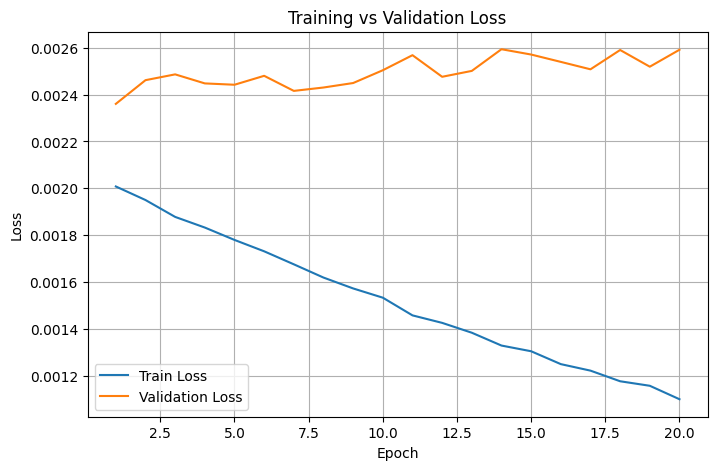

In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_dataset = SentenceRegressionDataset("train_20k.csv")
val_dataset = SentenceRegressionDataset("val_20k.csv")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

optimizer = AdamW(model.parameters(), lr=2e-5)
EPOCHS = 20

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        true_scores = batch["score"].cuda()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_scores = outputs.logits.squeeze()

        loss = F.mse_loss(predicted_scores, true_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

   
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].cuda()
            attention_mask = batch["attention_mask"].cuda()
            true_scores = batch["score"].cuda()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predicted_scores = outputs.logits.squeeze()

            loss = F.mse_loss(predicted_scores, true_scores)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f" Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### Sentence Ranking Function
Defines a rank_sentences() function that takes a raw document and uses the trained LoRA-augmented DistilBERT model to score each sentence individually. Sentences are ranked by predicted importance (based on ROUGE-L recall), and the top k sentences are returned as the extractive summary.

In [ ]:
from nltk.tokenize import sent_tokenize

def rank_sentences(document, model, tokenizer, top_k=3):
    model.eval()
    sentences = [s.strip() for s in sent_tokenize(document) if s.strip()]
    scored = []

    for sent in sentences:
        encoding = tokenizer(sent, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        input_ids = encoding['input_ids'].cuda()
        attention_mask = encoding['attention_mask'].cuda()

        with torch.no_grad():
            score = model(input_ids=input_ids, attention_mask=attention_mask).logits.item()
        scored.append((sent, score))

    ranked = sorted(scored, key=lambda x: x[1], reverse=True)[:top_k]
    return [s for s, _ in ranked]


In [103]:
!pip install peft==0.5.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.14.0
    Uninstalling peft-0.14.0:
      Successfully uninstalled peft-0.14.0


In [ ]:
import torch


tokenizer.save_pretrained("/kaggle/working/lora_tokenizer")

torch.save(model.state_dict(), "lora_full_model.pt")
print(" Full model saved as lora_full_model.pt")



 Full model saved as lora_full_model.pt


In [120]:
import shutil

shutil.make_archive("/kaggle/working/lora_tokenizer", 'zip', "/kaggle/working/lora_tokenizer")


'/kaggle/working/lora_tokenizer.zip'

### Ranked Sentence Scorer with Output
This debug version of the ranking function prints each sentence along with its predicted importance score - based on ROUGE-L recall. It highlights the top-k ranked sentences that form the extractive summary. Useful for validating model behavior during inference.

In [ ]:
def rank_sentences_debug(document, model, tokenizer, top_k=3):
    model.eval()
    sentences = [s.strip() for s in sent_tokenize(document) if s.strip()]
    scored = []

    print(" Sentence Scores:\n")
    for sent in sentences:
        encoding = tokenizer(sent, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        input_ids = encoding['input_ids'].cuda()
        attention_mask = encoding['attention_mask'].cuda()

        with torch.no_grad():
            score = model(input_ids=input_ids, attention_mask=attention_mask).logits.item()
        scored.append((sent, score))
        print(f"• {score:.4f} → {sent}")


    ranked = sorted(scored, key=lambda x: x[1], reverse=True)[:top_k]
    print("\n Top Extractive Summary:\n")
    for sent, score in ranked:
        print(f"•{sent}")
    
    return [s for s, _ in ranked]


In [ ]:
from datasets import load_dataset

test_set = load_dataset("ereverter/cnn_dailymail_extractive", split="test[:5%]")  


docs = [" ".join(x["src"]) for x in test_set]
refs = [" ".join(x["tgt"]) for x in test_set]


### ROUGE Scoring of Extractive Summaries

This method evaluates the extractive summarizer by computing ROUGE-1 and ROUGE-L F1 scores between reference summaries and top-k predicted sentences. For each document:

The sentences are sorted using the trained model.
Top-k sentences are combined into a candidate summary.
The ROUGE scores are calculated against the gold summary.
It computes and returns the average ROUGE-1 and ROUGE-L F1 scores of the dataset.

In [ ]:
from rouge_score import rouge_scorer
import numpy as np
from nltk.tokenize import sent_tokenize

def evaluate_rouge(model, tokenizer, docs, refs, top_k=3):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge1_scores = []
    rougeL_scores = []

    for doc, ref in zip(docs, refs):
       
        sentences = [s.strip() for s in sent_tokenize(doc) if s.strip()]
        scored = []

        for sent in sentences:
            encoding = tokenizer(sent, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
            input_ids = encoding["input_ids"].cuda()
            attention_mask = encoding["attention_mask"].cuda()
            with torch.no_grad():
                score = model(input_ids=input_ids, attention_mask=attention_mask).logits.item()
            scored.append((sent, score))

        ranked = sorted(scored, key=lambda x: x[1], reverse=True)[:top_k]
        candidate = " ".join([s for s, _ in ranked])

        scores = scorer.score(ref, candidate)
        rouge1_scores.append(scores["rouge1"].fmeasure)
        rougeL_scores.append(scores["rougeL"].fmeasure)

    return {
        "ROUGE-1": np.mean(rouge1_scores),
        "ROUGE-L": np.mean(rougeL_scores)
    }


In [117]:
results = evaluate_rouge(model, tokenizer, docs, refs, top_k=3)
print(f"ROUGE-1: {results['ROUGE-1']:.4f}")
print(f"ROUGE-L: {results['ROUGE-L']:.4f}")


ROUGE-1: 0.2538
ROUGE-L: 0.1653


 These scores reflect moderate lexical and structural overlap between the top-ranked extractive summaries and the reference summaries, indicating the model has learned to identify reasonably relevant content.

### Testing few Cases

In [119]:
doc = """
In recent years, the conversation around climate change has evolved from a scientific concern to a central topic in policy, economics, and public health. Governments worldwide are being urged by scientists and citizens alike to implement stricter emissions targets and invest heavily in renewable energy infrastructure. The 2023 IPCC report emphasized that the window to avoid the most catastrophic effects of climate change is rapidly closing. Rising sea levels threaten to displace millions living in coastal regions, while increasingly severe weather events like hurricanes, droughts, and wildfires are already causing billions in damage annually. At the same time, corporations are under pressure from both investors and consumers to adopt sustainable practices and disclose environmental impact data. Major tech companies have pledged carbon neutrality, and financial institutions are rethinking how they allocate capital to fossil fuel-dependent industries. However, progress remains uneven. Developing nations argue that they cannot be held to the same standards as industrialized countries, which have historically contributed the most to greenhouse gas accumulation. This has led to a renewed focus on climate justice — the idea that those least responsible for climate change are often the most vulnerable to its consequences. International cooperation remains crucial, especially as countries navigate economic recovery in the post-pandemic era. Initiatives like the Paris Agreement and COP28 are central to aligning global goals, but many experts believe that more aggressive timelines are necessary. Public awareness and activism, particularly among younger generations, continue to drive momentum toward meaningful, science-based climate action.


"""

summary = rank_sentences_debug(doc, model, tokenizer, top_k=5)


 Sentence Scores:

• 0.0691 → In recent years, the conversation around climate change has evolved from a scientific concern to a central topic in policy, economics, and public health.
• 0.0765 → Governments worldwide are being urged by scientists and citizens alike to implement stricter emissions targets and invest heavily in renewable energy infrastructure.
• 0.0498 → The 2023 IPCC report emphasized that the window to avoid the most catastrophic effects of climate change is rapidly closing.
• 0.0864 → Rising sea levels threaten to displace millions living in coastal regions, while increasingly severe weather events like hurricanes, droughts, and wildfires are already causing billions in damage annually.
• 0.0427 → At the same time, corporations are under pressure from both investors and consumers to adopt sustainable practices and disclose environmental impact data.
• 0.0742 → Major tech companies have pledged carbon neutrality, and financial institutions are rethinking how they alloc

In [129]:
doc = """
With the rapid advancement of artificial intelligence, lawmakers are scrambling to implement frameworks that ensure ethical and responsible use of AI. Recent proposals include mandatory algorithmic audits, transparency requirements, and strict oversight for models deployed in critical sectors like healthcare and law enforcement. Companies like OpenAI and Google DeepMind have welcomed regulation in principle, but caution that overly rigid rules may stifle innovation. Meanwhile, advocacy groups warn that without enforceable safeguards, AI systems could perpetuate bias, invade privacy, or even pose existential risks. The EU’s AI Act is currently the most comprehensive attempt at global regulation, expected to be finalized later this year.
"""
summary = rank_sentences_debug(doc, model, tokenizer, top_k=3)


 Sentence Scores:

• 0.0870 → With the rapid advancement of artificial intelligence, lawmakers are scrambling to implement frameworks that ensure ethical and responsible use of AI.
• 0.1050 → Recent proposals include mandatory algorithmic audits, transparency requirements, and strict oversight for models deployed in critical sectors like healthcare and law enforcement.
• 0.0833 → Companies like OpenAI and Google DeepMind have welcomed regulation in principle, but caution that overly rigid rules may stifle innovation.
• 0.0527 → Meanwhile, advocacy groups warn that without enforceable safeguards, AI systems could perpetuate bias, invade privacy, or even pose existential risks.
• 0.1307 → The EU’s AI Act is currently the most comprehensive attempt at global regulation, expected to be finalized later this year.

 Top Extractive Summary:

•The EU’s AI Act is currently the most comprehensive attempt at global regulation, expected to be finalized later this year.
•Recent proposals include ma

In [130]:
doc = """
After a decade of near-uninterrupted growth, the tech industry is facing its largest wave of layoffs since the dot-com crash. Companies like Meta, Amazon, and Google have announced large-scale job cuts, citing rising interest rates, inflationary pressures, and over-hiring during the pandemic. Analysts suggest this marks a correction rather than a collapse, with firms realigning their focus on profitability over scale. Workers affected by the layoffs are expressing both frustration and hope, with many turning to startups or considering career changes into adjacent industries like ed-tech and climate tech. Industry observers say the current downturn could spark a wave of new innovation.
"""
summary = rank_sentences_debug(doc, model, tokenizer, top_k=3)


 Sentence Scores:

• 0.0788 → After a decade of near-uninterrupted growth, the tech industry is facing its largest wave of layoffs since the dot-com crash.
• 0.0672 → Companies like Meta, Amazon, and Google have announced large-scale job cuts, citing rising interest rates, inflationary pressures, and over-hiring during the pandemic.
• 0.0707 → Analysts suggest this marks a correction rather than a collapse, with firms realigning their focus on profitability over scale.
• 0.1079 → Workers affected by the layoffs are expressing both frustration and hope, with many turning to startups or considering career changes into adjacent industries like ed-tech and climate tech.
• 0.0773 → Industry observers say the current downturn could spark a wave of new innovation.

 Top Extractive Summary:

•Workers affected by the layoffs are expressing both frustration and hope, with many turning to startups or considering career changes into adjacent industries like ed-tech and climate tech.
•After a decad

In [132]:
doc = """
Access to clean water remains one of the most pressing challenges in many developing countries. Recent reports by the WHO and UNICEF highlight that over 2 billion people lack access to safe drinking water. Climate change, poor infrastructure, and political instability further exacerbate the crisis. Nonprofits and governments are investing in low-cost filtration systems, rainwater harvesting, and public education campaigns. However, progress is uneven and often hampered by corruption or lack of funding. Experts warn that unless urgent action is taken, water insecurity could lead to mass displacement and regional conflicts in the near future.
"""
summary = rank_sentences_debug(doc, model, tokenizer, top_k=3)


 Sentence Scores:

• 0.0723 → Access to clean water remains one of the most pressing challenges in many developing countries.
• 0.1411 → Recent reports by the WHO and UNICEF highlight that over 2 billion people lack access to safe drinking water.
• 0.0752 → Climate change, poor infrastructure, and political instability further exacerbate the crisis.
• 0.0703 → Nonprofits and governments are investing in low-cost filtration systems, rainwater harvesting, and public education campaigns.
• 0.0502 → However, progress is uneven and often hampered by corruption or lack of funding.
• 0.0961 → Experts warn that unless urgent action is taken, water insecurity could lead to mass displacement and regional conflicts in the near future.

 Top Extractive Summary:

•Recent reports by the WHO and UNICEF highlight that over 2 billion people lack access to safe drinking water.
•Experts warn that unless urgent action is taken, water insecurity could lead to mass displacement and regional conflicts in the

## References

https://www.digitalocean.com/community/tutorials/bart-model-for-text-summarization-part1

https://huggingface.co/facebook/bart-large-cnn

https://www.width.ai/post/bart-text-summarization

https://medium.com/@sandyeep70/demystifying-text-summarization-with-deep-learning-ce08d99eda97

https://www.geeksforgeeks.org/website-summarizer-using-bart/

https://ieeexplore.ieee.org/document/9972639

https://medium.com/@sarowar.saurav10/6-useful-text-summarization-algorithm-in-python-dfc8a9d33074

https://www.geeksforgeeks.org/text-summarization-in-nlp/

https://medium.com/@ivavrtaric/t5-for-text-summarization-in-7-lines-of-code-b665c9e40771

https://huggingface.co/facebook/bart-large-cnn

https://paperswithcode.com/task/abstractive-text-summarization

https://www.exxactcorp.com/blog/deep-learning/extractive-summarization-with-llm-using-bert

https://colab.research.google.com/drive/1ZunuZ0zFRusvQN5K9sH4q5rCZe63urIL

https://medium.com/analytics-vidhya/text-summarization-using-bert-gpt2-xlnet-5ee80608e961